In [19]:
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 

In [20]:
class Generator(torch.nn.Module):

    def __init__(self, z_dim, channels_img, features_g):
        super(Generator,self).__init__()

        self.gen = torch.nn.Sequential(

            self._block(z_dim, features_g*16, 4, 1, 0), # 4x4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32

            torch.nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), # 64x64
            torch.nn.Tanh()

        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):

        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )

    def forward(self,x):
        return self.gen(x)

In [21]:
# input shape : (batch_size, 100, 1, 1)
gen = Generator(100, 3, 64)
gen.load_state_dict(torch.load('/Users/gursi/Desktop/ML/myML/GANs/WGAN_GP/models/gen223.pt', map_location='cpu'))
gen.eval()
print('model loaded')

model loaded


In [31]:
def post_process(img):
    t = torchvision.transforms.ToPILImage()
    return t(img.clamp(0,1))

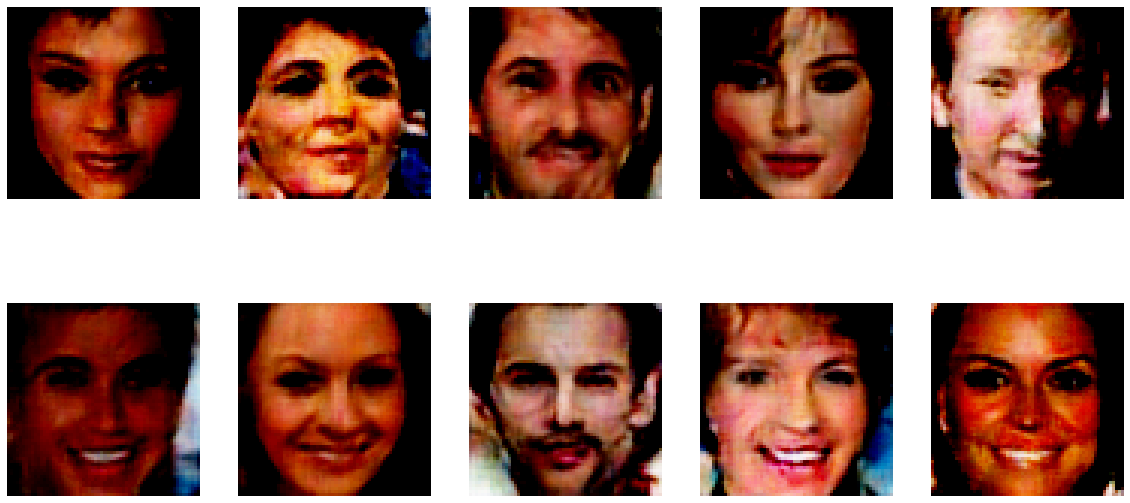

In [97]:
faces = 10
noise = torch.load('/users/gursi/desktop/good_noise.pt')
output = gen(noise)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
ax = ax.flatten()

for img,axis in zip(output,ax):
    img = post_process(img)
    axis.imshow(img)
    axis.axis(False)

In [98]:
latent_list = []
for i in range(faces-1):
    current_face = noise[i]
    next_face = noise[i+1]
    diff = next_face - current_face
    intervals = 30
    x = diff/intervals
    latent = torch.zeros((intervals, 100, 1, 1))

    for i2 in range(intervals): 
        img = current_face + (x * (i2+1))
        latent[i2] = img    

    latent_list.append(latent)

interpolated = torch.zeros((intervals*faces, 3, 64, 64))
counter = 0
for i in range(len(latent_list)):
    outputs = gen(latent_list[i])
    for i2 in outputs:
        interpolated[counter] = i2 
        counter += 1 

In [100]:
size = (interpolated.shape[-2], interpolated.shape[-1])
writer = cv2.VideoWriter('/users/gursi/desktop/output4.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, size)

for frame in interpolated : 

    output_img = np.array(post_process(frame))
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
 
    output_img = cv2.resize(output_img, size)
    writer.write(output_img)